In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

%load_ext IPython.extensions.autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from model import FinData
from functs import *
import ast

c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузим данные
df = pd.read_csv("examples\lerochka\Gazprom_short.csv", parse_dates=["utc"])

# Отбрасываем последнюю строку, так как мы не знаем close_{t+1}
df = df[:-1].copy()

# Добавим колонку с ценой продажи — close_{t+1}
df['future_close'] = df['close'].shift(-1)

# Параметры
budget = 10_000
commission_rate = 0.004  # 0.4%
budget_over_time = [budget]

for i, row in df.iterrows():
    proba = row['predicted_proba']
    buy_price = row['close']
    sell_price = row['future_close']

    if proba > 0.5:
        # Покупаем целое число акций
        num_shares = int(budget / (buy_price * (1 + commission_rate)))
        if num_shares > 0:
            # Сколько потратили с учетом комиссии
            total_cost = num_shares * buy_price * (1 + commission_rate)

            # Сколько выручили после продажи с учетом комиссии
            revenue = num_shares * sell_price * (1 - commission_rate)

            # Обновляем бюджет
            budget = budget - total_cost + revenue

    budget_over_time.append(budget)

# Построим график
plt.figure(figsize=(12, 6))
plt.plot(df["utc"], budget_over_time[1:], label="Бюджет")
plt.xlabel("Время")
plt.ylabel("Бюджет")
plt.title("Изменение бюджета при торговле по стратегии (прогноз > 0.5)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Gazprom_short.csv'

Смотрим 2024-2025 год

In [3]:
news_df = pd.read_csv('../markettwits_with_hashtags.csv')
data = FinData("../datasets/Gazprom_1_min.csv")

data.restrict_time_down(dt.datetime(2024, 1, 1))

# убираем информацию о часовом поясе 
news_df['Date'] = news_df['Date'].str.replace(r'\+00:00', '', regex=True)
news_df['Date'] = pd.to_datetime(news_df['Date'], errors='coerce')

In [4]:
news_df

ID                                               Text  \
0      315744               💥🇺🇸#INTC \nIntel назначил нового CEO   
1      315743  ✴️#крипто #наблюдение \nSantiment отмечает рез...   
2      315742         💥🇺🇸#TSLA = +7%  #NVDA = +6.5%  на закрытии   
3      315741  ⚠️🇨🇦#дкп #канада #спикеры \nЦБ обсуждал паузу ...   
4      315740  🛢🇺🇸#event #нефтегаз #сша \nРуководители нефтян...   
...       ...                                                ...   
43867  270925  🇺🇸#сша #отчетности\nкорпоративные отчетности С...   
43868  270924  ✴️#крипто #разблокировки #календарь \nCryptora...   
43869  270923  ✴️#крипто #разблокировки #календарь \nCryptora...   
43870  270921  🗓#календарь\nКЛЮЧЕВЫЕ СОБЫТИЯ ЭТОЙ НЕДЕЛИ:\n\n...   
43871  270920                                              💥🎄#нг   

                     Date                             list_of_hashtags  
0     2025-03-12 20:30:54                                    ['#INTC']  
1     2025-03-12 20:26:21                   ['#крипто', '#наблюдение']  
2     2025-03-12 20:20:07                           ['#TSLA', '#NVDA']  
3     2025-03-12 20:14:08              ['#дкп', '#канада', '#спикеры']  
4     2025-03-12 20:09:14              ['#event', '#нефтегаз', '#сша']  
...                   ...                                          ...  
43867 2024-01-01 15:34:44                      ['#сша', '#отчетности']  
43868 2024-01-01 15:30:52  ['#крипто', '#разблокировки', '#календарь']  
43869 2024-01-01 15:29:45  ['#крипто', '#разблокировки', '#календарь']  
43870 2024-01-01 15:24:42                               ['#календарь']  
43871 2024-01-01 14:17:40                                      ['#нг']  

[43872 rows x 4 columns]

In [5]:
news_df = news_df.dropna(subset=['Text', 'list_of_hashtags']).reset_index(drop=True)

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.7.0+cu118
11.8


In [9]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

df = news_df

batch_size = 64
embeddings = []

@torch.no_grad()
def get_batch_embeddings(batch_texts):
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS токен
    return cls_embeddings.cpu()

for i in tqdm(range(0, len(df), batch_size)):
    batch_texts = df["Text"].iloc[i:i+batch_size].tolist()
    batch_emb = get_batch_embeddings(batch_texts)
    embeddings.extend(batch_emb.numpy())

# Добавляем в DataFrame
embeddings_df = pd.DataFrame(embeddings, columns=[f'finbert_emb_{i}' for i in range(768)])
df = df.reset_index(drop=True)
df = pd.concat([df, embeddings_df], axis=1)

df.to_csv("news_with_finbert_embeddings.csv", index=False)


100%|██████████| 682/682 [05:31<00:00,  2.06it/s]


In [10]:
df

ID                                               Text  \
0      315744               💥🇺🇸#INTC \nIntel назначил нового CEO   
1      315743  ✴️#крипто #наблюдение \nSantiment отмечает рез...   
2      315742         💥🇺🇸#TSLA = +7%  #NVDA = +6.5%  на закрытии   
3      315741  ⚠️🇨🇦#дкп #канада #спикеры \nЦБ обсуждал паузу ...   
4      315740  🛢🇺🇸#event #нефтегаз #сша \nРуководители нефтян...   
...       ...                                                ...   
43598  270925  🇺🇸#сша #отчетности\nкорпоративные отчетности С...   
43599  270924  ✴️#крипто #разблокировки #календарь \nCryptora...   
43600  270923  ✴️#крипто #разблокировки #календарь \nCryptora...   
43601  270921  🗓#календарь\nКЛЮЧЕВЫЕ СОБЫТИЯ ЭТОЙ НЕДЕЛИ:\n\n...   
43602  270920                                              💥🎄#нг   

                     Date                             list_of_hashtags  \
0     2025-03-12 20:30:54                                    ['#INTC']   
1     2025-03-12 20:26:21                   ['#крипто', '#наблюдение']   
2     2025-03-12 20:20:07                           ['#TSLA', '#NVDA']   
3     2025-03-12 20:14:08              ['#дкп', '#канада', '#спикеры']   
4     2025-03-12 20:09:14              ['#event', '#нефтегаз', '#сша']   
...                   ...                                          ...   
43598 2024-01-01 15:34:44                      ['#сша', '#отчетности']   
43599 2024-01-01 15:30:52  ['#крипто', '#разблокировки', '#календарь']   
43600 2024-01-01 15:29:45  ['#крипто', '#разблокировки', '#календарь']   
43601 2024-01-01 15:24:42                               ['#календарь']   
43602 2024-01-01 14:17:40                                      ['#нг']   

       finbert_emb_0  finbert_emb_1  finbert_emb_2  finbert_emb_3  \
0          -1.406152      -0.934290      -0.793574       0.510786   
1          -1.044158       0.167712      -0.188574       0.087173   
2          -0.709750      -0.654955      -1.111583       0.469291   
3          -1.743612       0.311924      -0.599618       0.539284   
4          -1.700372       0.060650      -0.414726       0.083216   
...              ...            ...            ...            ...   
43598      -1.681653       0.335967      -0.535465      -0.011223   
43599      -1.509470      -0.144227      -0.472129       0.316908   
43600      -1.549335      -0.010760      -0.344851       0.226613   
43601      -1.007474      -0.064541      -0.619249       1.248166   
43602      -2.235441      -0.341212      -0.891574       0.143903   

       finbert_emb_4  finbert_emb_5  ...  finbert_emb_758  finbert_emb_759  \
0           1.341320      -0.899249  ...         1.365067         0.444096   
1           1.276051      -0.865672  ...         2.120698        -0.690363   
2           1.539417      -1.779076  ...         1.628097        -0.014542   
3           1.008345      -1.065089  ...         0.980241        -0.567163   
4           1.137861      -0.943485  ...         1.524428        -0.964408   
...              ...            ...  ...              ...              ...   
43598       1.200641      -1.092167  ...         0.644364        -0.693714   
43599       1.078614      -0.562036  ...         1.784911        -0.378460   
43600       0.864426      -0.802927  ...         1.735755        -0.627576   
43601       1.280192      -0.770563  ...         1.238193        -0.296273   
43602       1.312503      -1.138860  ...         0.334958         0.284593   

       finbert_emb_760  finbert_emb_761  finbert_emb_762  finbert_emb_763  \
0             0.285949        -0.268824        -0.330299         0.158232   
1             0.226766         0.244406        -0.671605         0.026429   
2             0.024976         0.073369        -0.677654         0.551929   
3             0.070609        -0.083955        -0.721109         0.022511   
4             0.553774         0.093348        -0.535756         0.152711   
...                ...              ...              ...              ...   


In [ ]:
news_df.sample(5)

In [108]:
news_df['list_of_hashtags'] = news_df['list_of_hashtags'].apply(ast.literal_eval)

In [148]:
news_df['adjusted_date'] = news_df.apply(adjust_news_time, axis=1)

KeyboardInterrupt: 

In [110]:
df = data.df
df = add_news_to_df(df, news_df, merge_row_df='utc', merge_row_news='adjusted_date')

In [111]:
# Фильтрация 
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-06-30 23:59:59')
df_3m = df[(df['utc'] >= start_date) & (df['utc'] <= end_date)].copy()

# Ключевые слова для поиска
keywords = ['#GAZP']

# Приводим к верхнему регистру для сопоставления без учёта регистра
keywords_upper = [kw.upper() for kw in keywords]

df_3m['has_tags'] = df_3m['hashtags'].apply(lambda tags: contains_keywords(tags, keywords_upper))

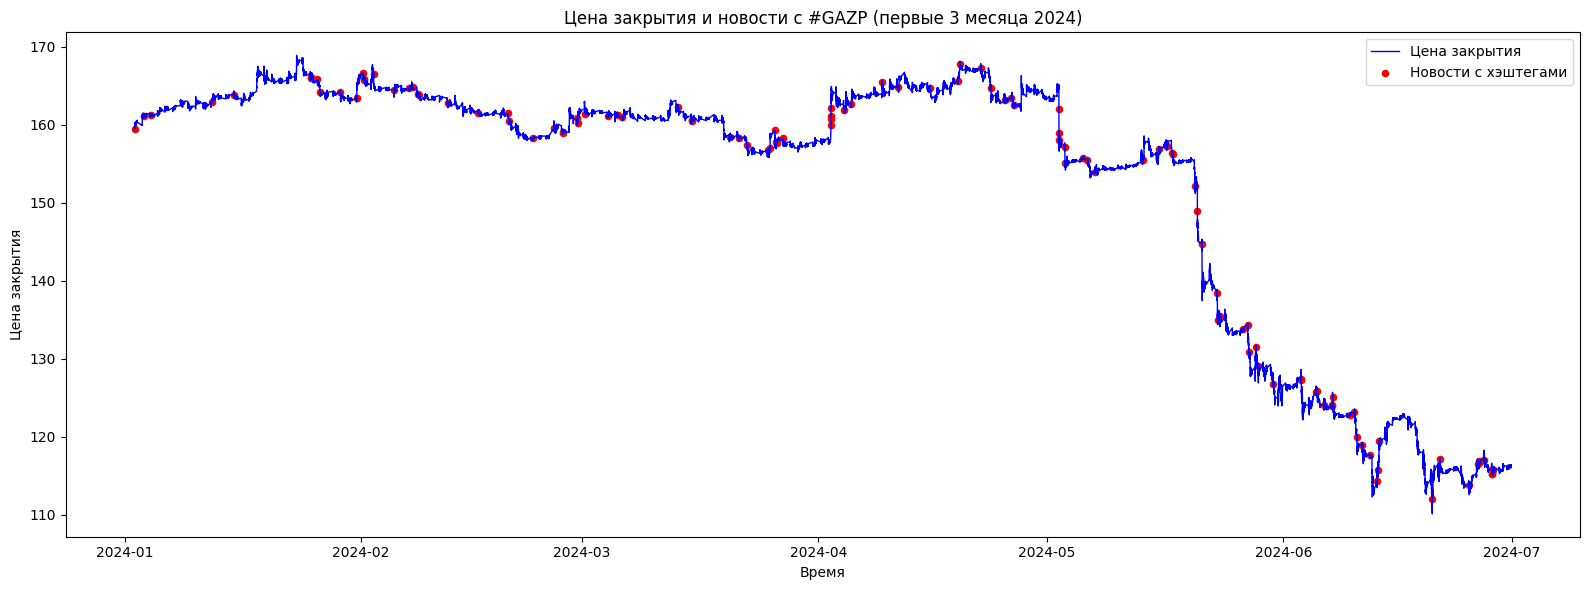

In [112]:
# Строим график
plt.figure(figsize=(16, 6))
plt.plot(df_3m['utc'], df_3m['close'], label='Цена закрытия', color='blue', linewidth=1)

# Отмечаем точки с новостями #GAZP
gazp_points = df_3m[df_3m['has_tags']]
plt.scatter(gazp_points['utc'], gazp_points['close'], color='red', s=20, label='Новости с хэштегами')

plt.xlabel('Время')
plt.ylabel('Цена закрытия')
plt.title('Цена закрытия и новости с #GAZP (первые 3 месяца 2024)')
plt.legend()
plt.tight_layout()
plt.show()


In [113]:
steps = [60, 120] 
df_3m_changes = compute_price_changes(df_3m, steps=steps)


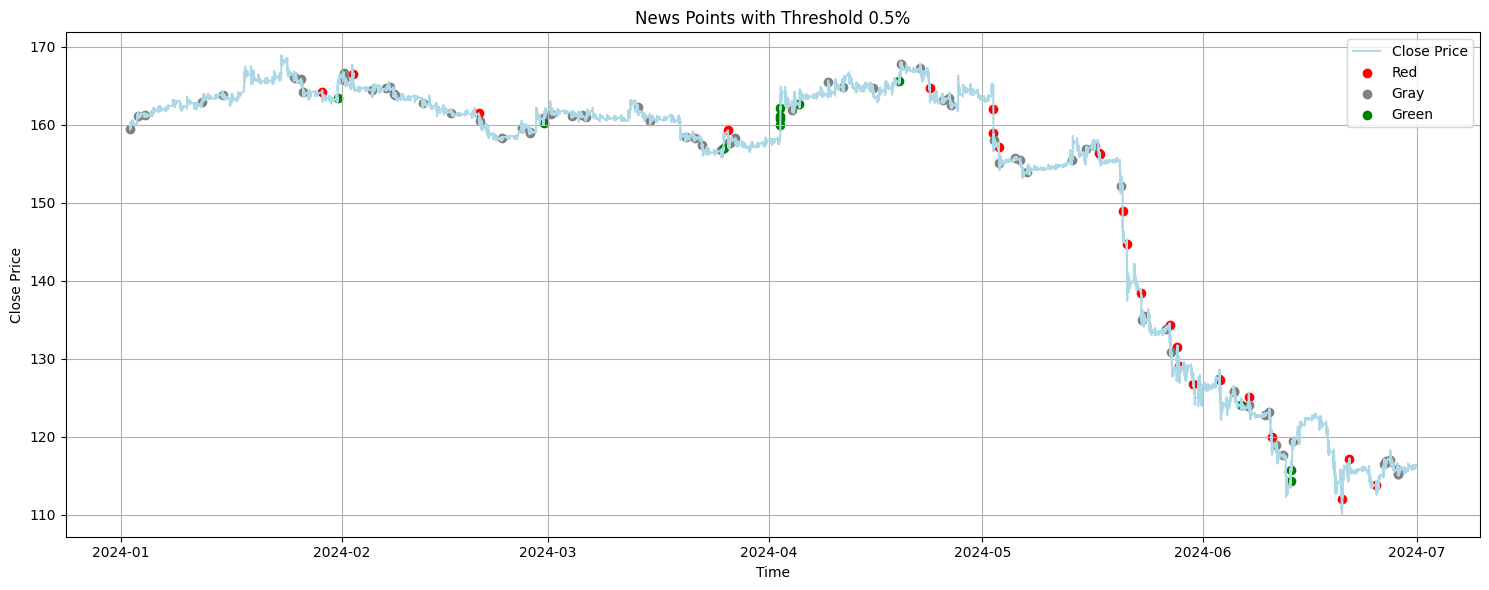

In [114]:
plot_news_points(df_3m_changes, threshold=0.5, steps=steps)


In [115]:
plot_interactive_news(df_3m_changes, threshold=0.5, steps=steps)

In [116]:
df_3m_changes[df_3m_changes.utc == dt.datetime(2024, 1, 22, 9, 1)].news

14299    [⚠️🇷🇺#санкции #россия \nСанкционное давление п...
Name: news, dtype: object

In [117]:
df_3m_changes = compute_price_changes_all(df_3m, steps)

In [118]:
df_3m_changes

utc    open   close    high     low  volume  \
0      2024-01-02 07:17:00  160.33  159.42  160.33  159.42     162   
1      2024-01-02 07:18:00  160.29  160.28  160.29  159.42      56   
2      2024-01-02 07:19:00  159.45  159.48  160.28  159.45     108   
3      2024-01-02 07:20:00  159.48  160.17  160.19  159.47      54   
4      2024-01-02 07:21:00  160.00  160.14  160.16  159.90      72   
...                    ...     ...     ...     ...     ...     ...   
138063 2024-06-30 20:44:00  116.30  116.30  116.30  116.30      82   
138064 2024-06-30 20:45:00  116.30  116.34  116.34  116.30      48   
138065 2024-06-30 20:47:00  116.30  116.30  116.30  116.30      34   
138066 2024-06-30 20:48:00  116.30  116.30  116.30  116.30       2   
138067 2024-06-30 20:49:00  116.30  116.30  116.30  116.30      10   

        direction_binary_0  direction_binary_1  \
0                        1                   1   
1                        0                   0   
2                        1                   1   
3                        0                   0   
4                        1                   1   
...                    ...                 ...   
138063                   1                   1   
138064                   0                   0   
138065                   0                   1   
138066                   0                   1   
138067                   0                   0   

                                                     news  \
0       [🇺🇸#акции #сша #история #наблюдение \nИсториче...   
1                                                      []   
2                                                      []   
3                                                      []   
4                                                      []   
...                                                   ...   
138063                                                 []   
138064                                                 []   
138065                                                 []   
138066                                                 []   
138067                                                 []   

                                                    dates  \
0       [2024-01-01 18:09:45, 2024-01-01 17:59:40, 202...   
1                                                      []   
2                                                      []   
3                                                      []   
4                                                      []   
...                                                   ...   
138063                                                 []   
138064                                                 []   
138065                                                 []   
138066                                                 []   
138067                                                 []   

                                                 hashtags  has_tags  \
0       [[#акции, #сша, #история, #наблюдение, #sentim...      True   
1                                                      []     False   
2                                                      []     False   
3                                                      []     False   
4                                                      []     False   
...                                                   ...       ...   
138063                                                 []     False   
138064                                                 []     False   
138065                                                 []     False   
138066                                                 []     False   
138067                                                 []     False   

        pct_change_60  pct_change_120  
0            0.357546        0.213273  
1           -0.380584       -0.305715  
2            0.300978        0.225734  
3           -0.137354       -0.049947  
4           -0.137380       -0.024978  
...               ... 

In [119]:
from collections import defaultdict
import numpy as np
import pandas as pd

def compute_hashtag_influence(df, change_col='pct_change_10'):
    """
    Считает среднее абсолютное влияние на цену закрытия для каждого уникального хэштега.

    Параметры:
    - df : DataFrame с колонкой 'hashtags' (список списков хэштегов) и колонкой изменения цены
    - change_col : имя колонки с процентным изменением цены (по умолчанию 'pct_change_10')

    Возвращает:
    - DataFrame с колонками: hashtag, mean_abs_influence, count
    """
    hashtag_to_changes = defaultdict(list)

    # Только строки, где значение изменения определено
    filtered_df = df[df[change_col].notna()]

    for _, row in filtered_df.iterrows():
        pct_change = abs(row[change_col])
        all_hashtags = set(tag for sublist in row["hashtags"] for tag in sublist)

        for tag in all_hashtags:
            hashtag_to_changes[tag].append(pct_change)

    # Преобразуем словарь в таблицу
    stats = pd.DataFrame([
        {
            "hashtag": tag,
            "mean_abs_influence": np.mean(changes),
            "counts": len(changes)
        }
        for tag, changes in hashtag_to_changes.items()
    ])

    # Сортируем по убыванию влияния
    stats = stats.sort_values("mean_abs_influence", ascending=False).reset_index(drop=True)
    return stats


hashtag_impact = compute_hashtag_influence(df_3m_changes, change_col='pct_change_120')
display(hashtag_impact[hashtag_impact.counts > 50].head(30))

hashtag  mean_abs_influence  counts
250         #MOEX            0.582241      73
365         #GAZP            0.493143     114
371         #NVTK            0.490581      65
402       #налоги            0.467474     115
440      #markets            0.443935     127
450         #VTBR            0.438796      59
454      #украина            0.437743     127
476  #токенизация            0.422508      51
478     #дивиденд            0.421965     442
483         #SPBE            0.420605      52
484         #RTKM            0.419977      52
491         #meme            0.417351     151
504         #авиа            0.409984      52
509       #выборы            0.408044     183
519  #конфискация            0.405114      93
522  #интервенции            0.403236      85
535       #япония            0.399808     121
537         #MTSS            0.399271      57
540         #NVDA            0.397100     119
546          #spo            0.396251      72
550      #санкции            0.395672     355
556          #SOL            0.393991     103
571         #SBER            0.389766     105
572          #JPY            0.388246      66
588     #инфляция            0.383846     274
589         #нато            0.383287      60
596  #стейблкоины            0.380636      74
597        #бонды            0.380536     188
602          #ETH            0.379669     299
603        #event            0.379300     165

In [120]:
hashtags_for_Gazprom = ['#MOEX', '#GAZP', '#NVTK', '#газ', 
                        '#markets', '#украина', '#дивиденд', 
                        '#санкции', '#налоги', '##VTBR', 
                        '#конфискация']

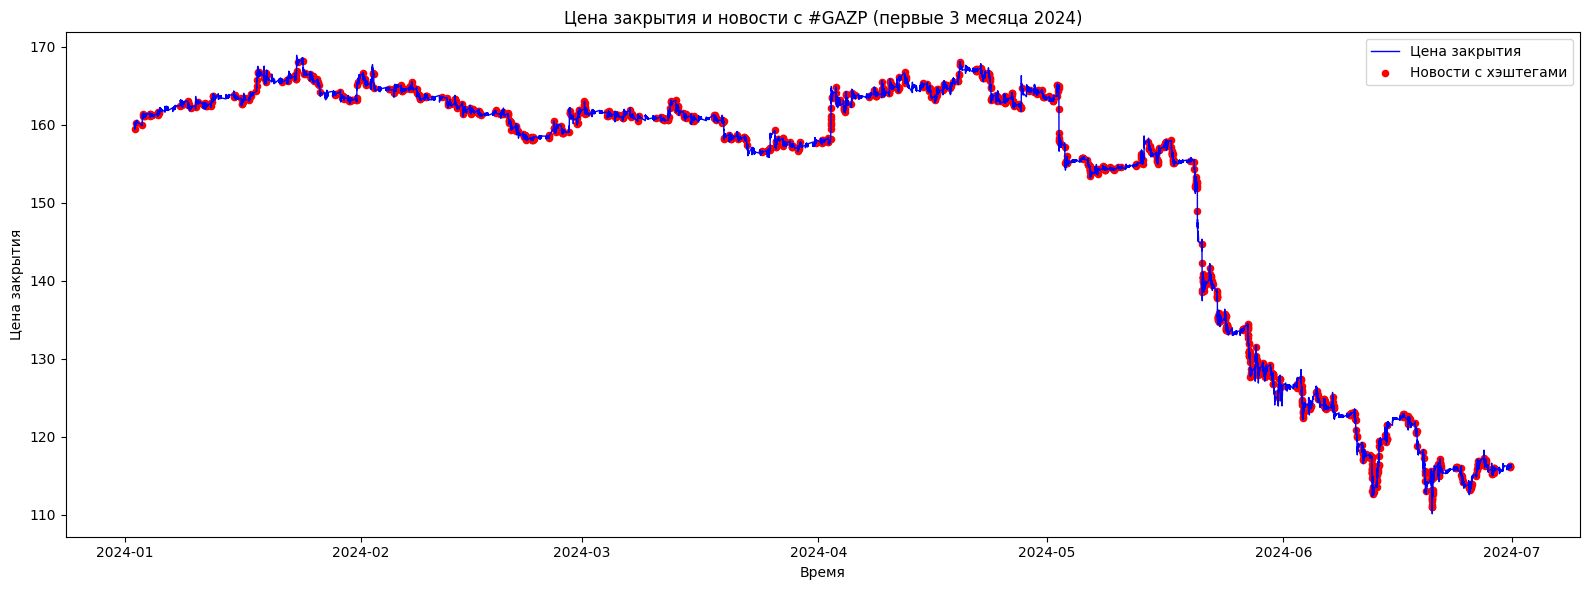

In [121]:
# Приводим к верхнему регистру для сопоставления без учёта регистра
hashtags_for_Gazprom = [kw.upper() for kw in hashtags_for_Gazprom]

df_3m['has_tags'] = df_3m['hashtags'].apply(lambda tags: contains_keywords(tags, hashtags_for_Gazprom))

# Строим график
plt.figure(figsize=(16, 6))
plt.plot(df_3m['utc'], df_3m['close'], label='Цена закрытия', color='blue', linewidth=1)

# Отмечаем точки с новостями #GAZP
gazp_points = df_3m[df_3m['has_tags']]
plt.scatter(gazp_points['utc'], gazp_points['close'], color='red', s=20, label='Новости с хэштегами')

plt.xlabel('Время')
plt.ylabel('Цена закрытия')
plt.title('Цена закрытия и новости с #GAZP (первые 3 месяца 2024)')
plt.legend()
plt.tight_layout()
plt.show()

In [122]:
steps = [60, 120] 
df_3m_changes = compute_price_changes(df_3m, steps=steps)

In [123]:
df_3m_changes_restr = df_3m_changes[df_3m_changes.utc > dt.datetime(2024, 5, 1)]

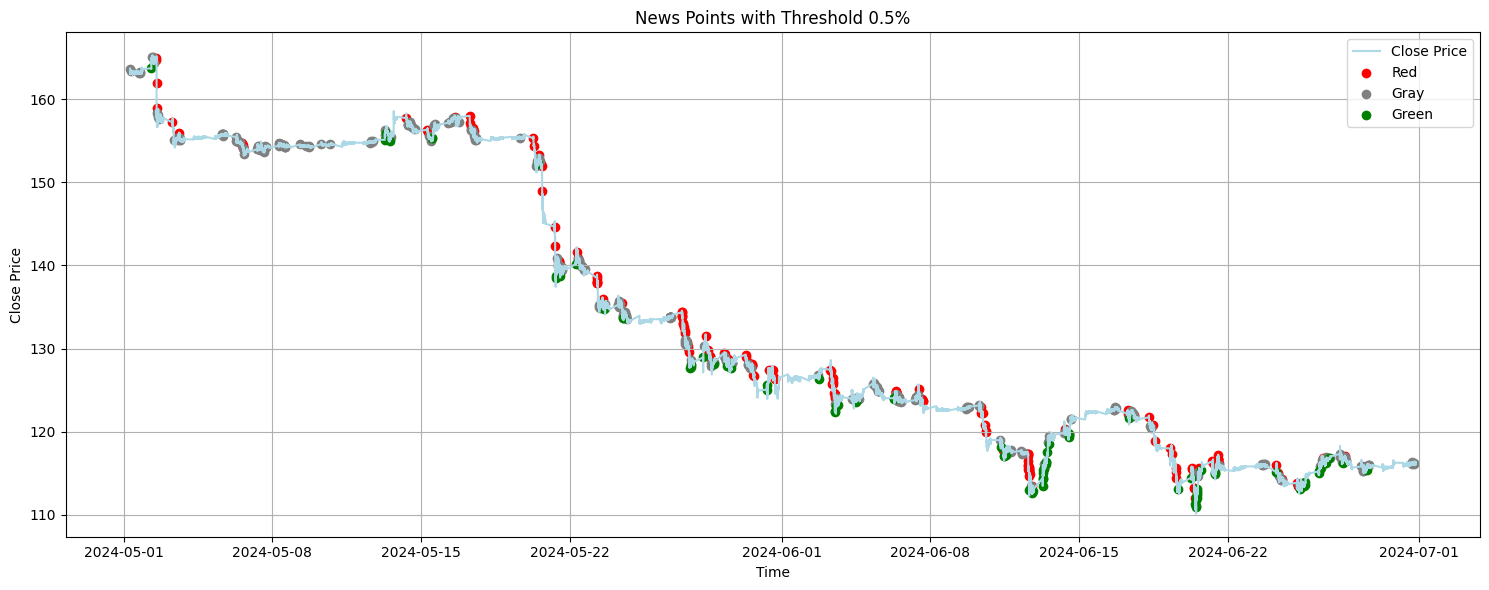

In [124]:
plot_news_points(df_3m_changes_restr, threshold=0.5, steps=steps)

Оценим производные для изменения цены: 

In [125]:
def compute_derivatives_for_significant_tagged_news(
    df,
    change_col='pct_change_120',
    change_threshold=0.5,
    window_size=10,
    num_windows=5,
    price_col='close'
):
    """
    Считает производные (модули) по окнам только для строк, где:
    - has_tags == True
    - abs(change_col) >= change_threshold

    Параметры:
    - df : DataFrame с колонками 'has_tags', change_col и price_col
    - change_col : колонка с % изменением цены
    - change_threshold : порог значимого изменения
    - window_size : длина одного окна (в свечах)
    - num_windows : количество окон
    - price_col : колонка с ценой

    Возвращает:
    - DataFrame с производными по окнам: deriv_0, deriv_1, ..., deriv_{n}
    """
    df = df.reset_index(drop=True)
    result_rows = []

    for idx, row in df.iterrows():
        # фильтруем по наличию тега и изменению
        if not row.get("has_tags", False):
            continue
        change = row.get(change_col)
        if pd.isna(change) or abs(change) < change_threshold:
            continue

        derivs = {'index': idx, 'utc': row.get('utc')}
        out_of_bounds = False

        for w in range(num_windows):
            start_idx = idx + w * window_size
            end_idx = start_idx + window_size - 1

            if end_idx >= len(df):
                out_of_bounds = True
                break

            p_start = df.at[start_idx, price_col]
            p_end = df.at[end_idx, price_col]

            if p_start == 0:
                derivs[f'deriv_{w}'] = np.nan
            else:
                change_pct = (p_end - p_start) / p_start * 100
                derivs[f'deriv_{w}'] = abs(change_pct) / window_size

        if not out_of_bounds:
            result_rows.append(derivs)

    return pd.DataFrame(result_rows)


In [126]:
filtered = df_3m_changes[
    (df_3m_changes['has_tags']) &
    (df_3m_changes['pct_change_120'].abs() >= 0.5)
]
filtered.shape

(299, 14)

In [127]:
df_derivs = compute_derivatives_for_significant_tagged_news(df_3m_changes)

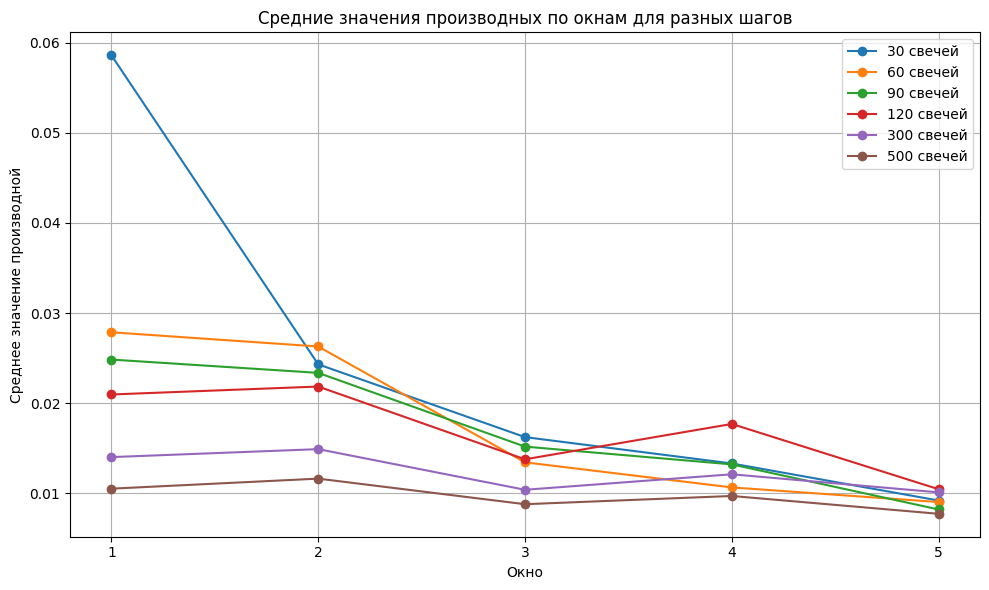

In [128]:
# Шаги для анализа
steps_list = [30, 60, 90, 120, 300, 500]
window_size = 30
num_windows = 5
change_threshold = 1

# Для хранения результатов
mean_derivs_dict = {}

for step in steps_list:
    # 1. Посчитать изменения цен для текущего шага
    df_changes = compute_price_changes_all(df_3m, steps=[step])
    change_col = f'pct_change_{step}'
    hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
    hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

    top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
    df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

    # 4. Посчитать производные по новостям с этими хэштегами и значимым изменением
    df_derivs_step = compute_derivatives_for_significant_tagged_news(
        df_changes,
        change_col=change_col,
        change_threshold=change_threshold,
        window_size=window_size,
        num_windows=num_windows,
        price_col='close'
    )

    # 5. Средние значения производных по окнам
    if not df_derivs_step.empty:
        mean_derivs = df_derivs_step[[f'deriv_{i}' for i in range(num_windows)]].mean()
        mean_derivs_dict[step] = mean_derivs

# Визуализация
plt.figure(figsize=(10, 6))
for step, mean_derivs in mean_derivs_dict.items():
    plt.plot(range(1, num_windows + 1), mean_derivs.values, marker='o', label=f'{step} свечей')
plt.xlabel('Окно')
plt.ylabel('Среднее значение производной')
plt.title('Средние значения производных по окнам для разных шагов')
plt.xticks(range(1, num_windows + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

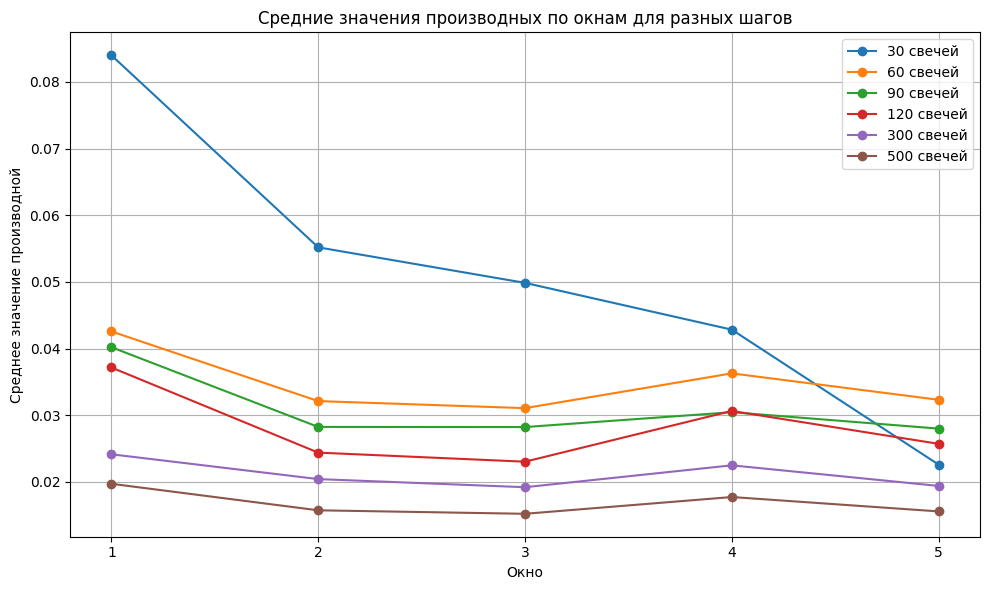

In [129]:
# Шаги для анализа
steps_list = [30, 60, 90, 120, 300, 500]
window_size = 10
num_windows = 5
change_threshold = 1

# Для хранения результатов
mean_derivs_dict = {}

for step in steps_list:
    # 1. Посчитать изменения цен для текущего шага
    df_changes = compute_price_changes_all(df_3m, steps=[step])
    change_col = f'pct_change_{step}'
    hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
    hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

    top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
    df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

    # 4. Посчитать производные по новостям с этими хэштегами и значимым изменением
    df_derivs_step = compute_derivatives_for_significant_tagged_news(
        df_changes,
        change_col=change_col,
        change_threshold=change_threshold,
        window_size=window_size,
        num_windows=num_windows,
        price_col='close'
    )

    # 5. Средние значения производных по окнам
    if not df_derivs_step.empty:
        mean_derivs = df_derivs_step[[f'deriv_{i}' for i in range(num_windows)]].mean()
        mean_derivs_dict[step] = mean_derivs

# Визуализация
plt.figure(figsize=(10, 6))
for step, mean_derivs in mean_derivs_dict.items():
    plt.plot(range(1, num_windows + 1), mean_derivs.values, marker='o', label=f'{step} свечей')
plt.xlabel('Окно')
plt.ylabel('Среднее значение производной')
plt.title('Средние значения производных по окнам для разных шагов')
plt.xticks(range(1, num_windows + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

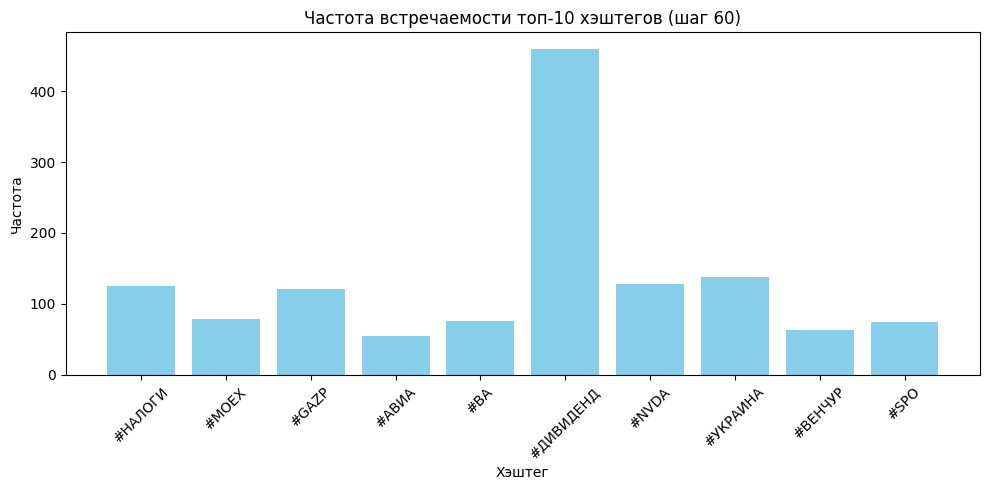

In [130]:
from collections import Counter

# Выбираем шаг 60
step = 60
change_col = f'pct_change_{step}'

# Получаем топ-10 хэштегов с частотой > 50
hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

# Приводим к верхнему регистру для сопоставления
top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]

# Фильтруем строки, где есть хотя бы один из топ-хэштегов
def has_any_top_hashtag(tags):
    tags_flat = [tag.upper() for sublist in tags for tag in (sublist if isinstance(sublist, list) else [sublist])]
    return any(h in tags_flat for h in top_hashtags_upper)

filtered_rows = df_3m[df_3m['hashtags'].apply(has_any_top_hashtag)]

# Считаем частоты встречаемости каждого хэштега из топа

all_tags = []
for tags in filtered_rows['hashtags']:
    for sublist in tags:
        if isinstance(sublist, list):
            all_tags.extend([tag.upper() for tag in sublist if tag.upper() in top_hashtags_upper])
        elif isinstance(sublist, str):
            tag = sublist.upper()
            if tag in top_hashtags_upper:
                all_tags.append(tag)

tag_counts = Counter(all_tags)
tag_counts = {tag: tag_counts[tag] for tag in top_hashtags_upper}

# Барплот
plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.xlabel('Хэштег')
plt.ylabel('Частота')
plt.title('Частота встречаемости топ-10 хэштегов (шаг 60)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [131]:
# Параметры
step = 60


df_changes = compute_price_changes_all(df_3m, steps=[step])
change_col = f'pct_change_{step}'
hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

change_col = f'pct_change_{step}'
change_threshold = 0.8
top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]

print(top_hashtags_upper)

def get_upper_tags(tags):
    result = []
    if isinstance(tags, list):
        for t in tags:
            if isinstance(t, list):
                result.extend([x.upper() for x in t if isinstance(x, str)])
            elif isinstance(t, str):
                result.append(t.upper())
    return result


df_changes['hashtags_upper'] = df_changes['hashtags'].apply(get_upper_tags)
# print(df_changes)
# print(df_changes['hashtags_upper'])

# Подсчёт реакции на каждый хэштег
hashtag_stats = []

for hashtag in top_hashtags_upper:
    rows_with_tag = df_changes[
        (df_changes['hashtags_upper'].apply(lambda tags: hashtag in tags)) &
        (df_changes[change_col].abs() >= change_threshold)
    ]

    changes = []
    for _, row in rows_with_tag.iterrows():
        news_list = row['news']
        tag_list = row['hashtags']
        if not isinstance(news_list, list) or not isinstance(tag_list, list):
            continue
        for tags in tag_list:
            tags_upper = [t.upper() for t in tags if isinstance(t, str)]
            if hashtag in tags_upper:
                changes.append(abs(row[change_col]))
                break  # один раз на новость

    if changes:
        mean_change = np.mean(changes)
        median_change = np.median(changes)
        hashtag_stats.append((hashtag, mean_change, median_change, len(changes)))

# Сортировка по среднему изменению
hashtag_stats.sort(key=lambda x: x[1], reverse=True)

# Вывод
print("Топ хэштегов по реакции компании:")
print(f"{'Хэштег':<15} {'Среднее изменение':<20} {'Медиана':<12} {'N новостей'}")
for tag, mean_c, med_c, count in hashtag_stats:
    print(f"{tag:<15} {mean_c:<20.4f} {med_c:<12.4f} {count}")


non_top_rows = df_changes[
    df_changes['hashtags_upper'].apply(lambda tags: any(t not in top_hashtags_upper for t in tags))
]

changes_non_top = non_top_rows[change_col].abs()

mean_change_non_top = changes_non_top.mean()
median_change_non_top = changes_non_top.median()
count_non_top = len(changes_non_top)

no_news_rows = df_changes[
    df_changes['hashtags_upper'].apply(lambda tags: len(tags) == 0)
]


changes_no_news = no_news_rows[change_col].abs()

mean_change_no_news = changes_no_news.mean()
median_change_no_news = changes_no_news.median()
count_no_news = len(changes_no_news)


print("\nКонтрольные выборки:")

print(f"{'Категория':<25} {'Среднее изменение':<20} {'Медиана':<12} {'N'}")
print(f"{'НЕ топ-хэштеги':<25} {mean_change_non_top:<20.4f} {median_change_non_top:<12.4f} {count_non_top}")
print(f"{'Без новостей':<25} {mean_change_no_news:<20.4f} {median_change_no_news:<12.4f} {count_no_news}")



['#GAZP', '#MOEX', '#NVTK', '#MARKETS', '#НАЛОГИ', '#SPBE', '#RTKM', '#VTBR', '#MTSS', '#УКРАИНА']
Топ хэштегов по реакции компании:
Хэштег          Среднее изменение    Медиана      N новостей
#RTKM           1.8148               1.5669       5
#SPBE           1.7474               1.1374       5
#GAZP           1.7159               1.4375       19
#MTSS           1.5227               1.5972       4
#НАЛОГИ         1.4658               1.2472       13
#NVTK           1.4597               1.3512       10
#MOEX           1.4375               1.1248       14
#УКРАИНА        1.3980               1.1488       11
#MARKETS        1.3538               1.0936       11
#VTBR           1.2265               1.1910       7

Контрольные выборки:
Категория                 Среднее изменение    Медиана      N
НЕ топ-хэштеги            0.2224               0.1264       11191
Без новостей              0.1716               0.0971       126764


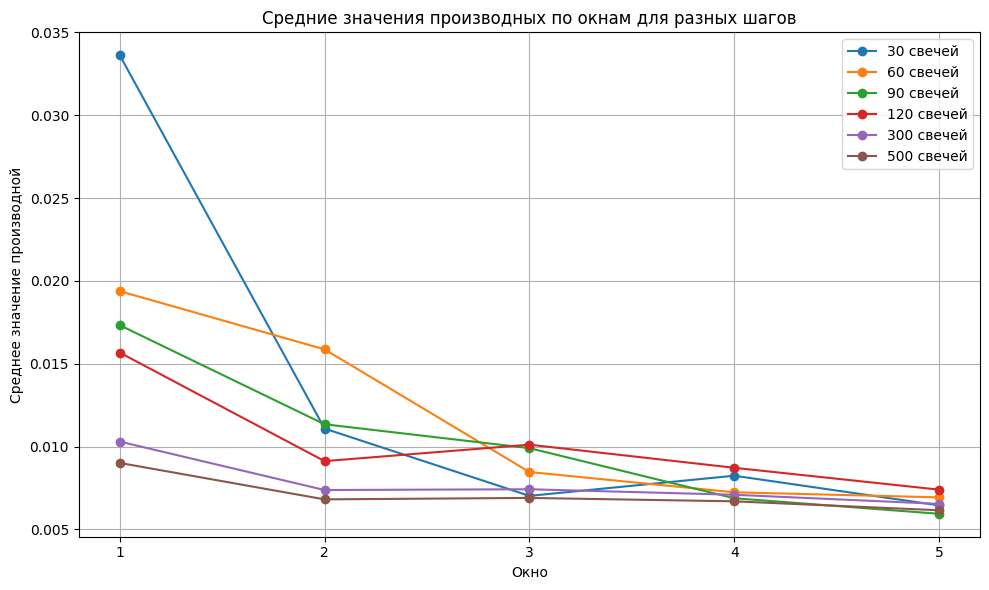

In [132]:
data = FinData("../datasets/MTS_1_min.csv")
df = data.df
df = add_news_to_df(df, news_df, merge_row_df='utc', merge_row_news='adjusted_date')

# Фильтрация 
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-06-30 23:59:59')
df_3m = df[(df['utc'] >= start_date) & (df['utc'] <= end_date)].copy()


# Шаги для анализа
steps_list = [30, 60, 90, 120, 300, 500]
window_size = 30
num_windows = 5
change_threshold = 0.6

# Для хранения результатов
mean_derivs_dict = {}

for step in steps_list:
    # 1. Посчитать изменения цен для текущего шага
    df_changes = compute_price_changes_all(df_3m, steps=[step])
    change_col = f'pct_change_{step}'
    hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
    hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

    top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
    df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

    # 4. Посчитать производные по новостям с этими хэштегами и значимым изменением
    df_derivs_step = compute_derivatives_for_significant_tagged_news(
        df_changes,
        change_col=change_col,
        change_threshold=change_threshold,
        window_size=window_size,
        num_windows=num_windows,
        price_col='close'
    )

    # 5. Средние значения производных по окнам
    if not df_derivs_step.empty:
        mean_derivs = df_derivs_step[[f'deriv_{i}' for i in range(num_windows)]].mean()
        mean_derivs_dict[step] = mean_derivs

# Визуализация
plt.figure(figsize=(10, 6))
for step, mean_derivs in mean_derivs_dict.items():
    plt.plot(range(1, num_windows + 1), mean_derivs.values, marker='o', label=f'{step} свечей')
plt.xlabel('Окно')
plt.ylabel('Среднее значение производной')
plt.title('Средние значения производных по окнам для разных шагов')
plt.xticks(range(1, num_windows + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

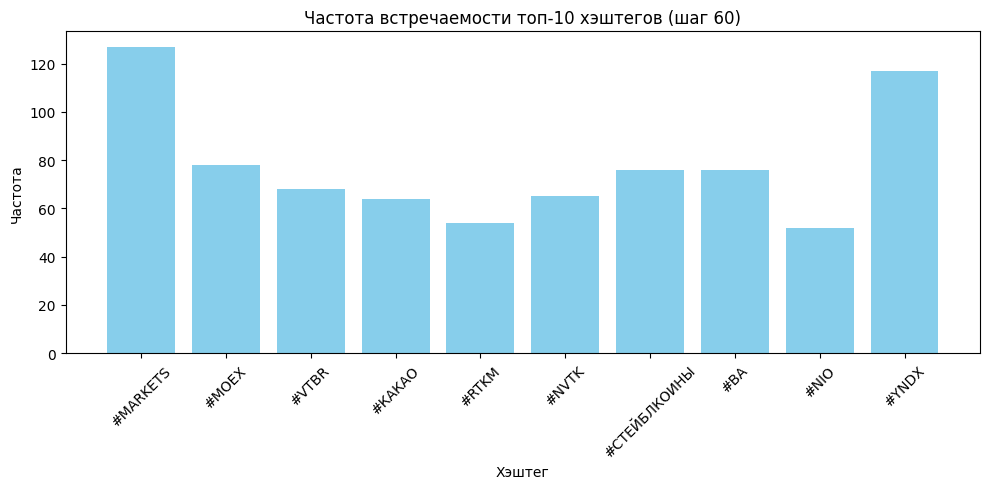

In [146]:
from collections import Counter

# Выбираем шаг 60
step = 60
change_col = f'pct_change_{step}'

df_changes = compute_price_changes_all(df_3m, steps=[step])
change_col = f'pct_change_{step}'
hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

# Приводим к верхнему регистру для сопоставления
top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]

# Фильтруем строки, где есть хотя бы один из топ-хэштегов
def has_any_top_hashtag(tags):
    tags_flat = [tag.upper() for sublist in tags for tag in (sublist if isinstance(sublist, list) else [sublist])]
    return any(h in tags_flat for h in top_hashtags_upper)

filtered_rows = df_3m[df_3m['hashtags'].apply(has_any_top_hashtag)]

# Считаем частоты встречаемости каждого хэштега из топа

all_tags = []
for tags in filtered_rows['hashtags']:
    for sublist in tags:
        if isinstance(sublist, list):
            all_tags.extend([tag.upper() for tag in sublist if tag.upper() in top_hashtags_upper])
        elif isinstance(sublist, str):
            tag = sublist.upper()
            if tag in top_hashtags_upper:
                all_tags.append(tag)

tag_counts = Counter(all_tags)
tag_counts = {tag: tag_counts[tag] for tag in top_hashtags_upper}

# Барплот
plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.xlabel('Хэштег')
plt.ylabel('Частота')
plt.title('Частота встречаемости топ-10 хэштегов (шаг 60)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [147]:
# Параметры
step = 60


df_changes = compute_price_changes_all(df_3m, steps=[step])
change_col = f'pct_change_{step}'
hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

change_col = f'pct_change_{step}'
change_threshold = 0.6
top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]

print(top_hashtags_upper)

def get_upper_tags(tags):
    result = []
    if isinstance(tags, list):
        for t in tags:
            if isinstance(t, list):
                result.extend([x.upper() for x in t if isinstance(x, str)])
            elif isinstance(t, str):
                result.append(t.upper())
    return result


df_changes['hashtags_upper'] = df_changes['hashtags'].apply(get_upper_tags)
# print(df_changes)
# print(df_changes['hashtags_upper'])

# Подсчёт реакции на каждый хэштег
hashtag_stats = []

for hashtag in top_hashtags_upper:
    rows_with_tag = df_changes[
        (df_changes['hashtags_upper'].apply(lambda tags: hashtag in tags)) &
        (df_changes[change_col].abs() >= change_threshold)
    ]

    changes = []
    for _, row in rows_with_tag.iterrows():
        news_list = row['news']
        tag_list = row['hashtags']
        if not isinstance(news_list, list) or not isinstance(tag_list, list):
            continue
        for tags in tag_list:
            tags_upper = [t.upper() for t in tags if isinstance(t, str)]
            if hashtag in tags_upper:
                changes.append(abs(row[change_col]))
                break  # один раз на новость

    if changes:
        mean_change = np.mean(changes)
        median_change = np.median(changes)
        hashtag_stats.append((hashtag, mean_change, median_change, len(changes)))

# Сортировка по среднему изменению
hashtag_stats.sort(key=lambda x: x[1], reverse=True)

# Вывод
print("Топ хэштегов по реакции компании:")
print(f"{'Хэштег':<15} {'Среднее изменение':<20} {'Медиана':<12} {'N новостей'}")
for tag, mean_c, med_c, count in hashtag_stats:
    print(f"{tag:<15} {mean_c:<20.4f} {med_c:<12.4f} {count}")


non_top_rows = df_changes[
    df_changes['hashtags_upper'].apply(lambda tags: any(t not in top_hashtags_upper for t in tags))
]

changes_non_top = non_top_rows[change_col].abs()

mean_change_non_top = changes_non_top.mean()
median_change_non_top = changes_non_top.median()
count_non_top = len(changes_non_top)

no_news_rows = df_changes[
    df_changes['hashtags_upper'].apply(lambda tags: len(tags) == 0)
]


changes_no_news = no_news_rows[change_col].abs()

mean_change_no_news = changes_no_news.mean()
median_change_no_news = changes_no_news.median()
count_no_news = len(changes_no_news)


print("\nКонтрольные выборки:")

print(f"{'Категория':<25} {'Среднее изменение':<20} {'Медиана':<12} {'N'}")
print(f"{'НЕ топ-хэштеги':<25} {mean_change_non_top:<20.4f} {median_change_non_top:<12.4f} {count_non_top}")
print(f"{'Без новостей':<25} {mean_change_no_news:<20.4f} {median_change_no_news:<12.4f} {count_no_news}")



['#MARKETS', '#MOEX', '#VTBR', '#КАКАО', '#RTKM', '#NVTK', '#СТЕЙБЛКОИНЫ', '#BA', '#NIO', '#YNDX']
Топ хэштегов по реакции компании:
Хэштег          Среднее изменение    Медиана      N новостей
#VTBR           1.8075               1.3409       20
#MOEX           1.7867               1.3989       27
#YNDX           1.6674               1.2387       35
#RTKM           1.6249               1.0823       21
#СТЕЙБЛКОИНЫ    1.5100               1.1460       28
#MARKETS        1.4798               1.0727       70
#NIO            1.4472               1.0199       20
#NVTK           1.4054               1.0922       31
#BA             1.4022               1.0300       30
#КАКАО          1.3842               1.0362       29

Контрольные выборки:
Категория                 Среднее изменение    Медиана      N
НЕ топ-хэштеги            0.4320               0.2635       10504
Без новостей              0.3802               0.2181       95832


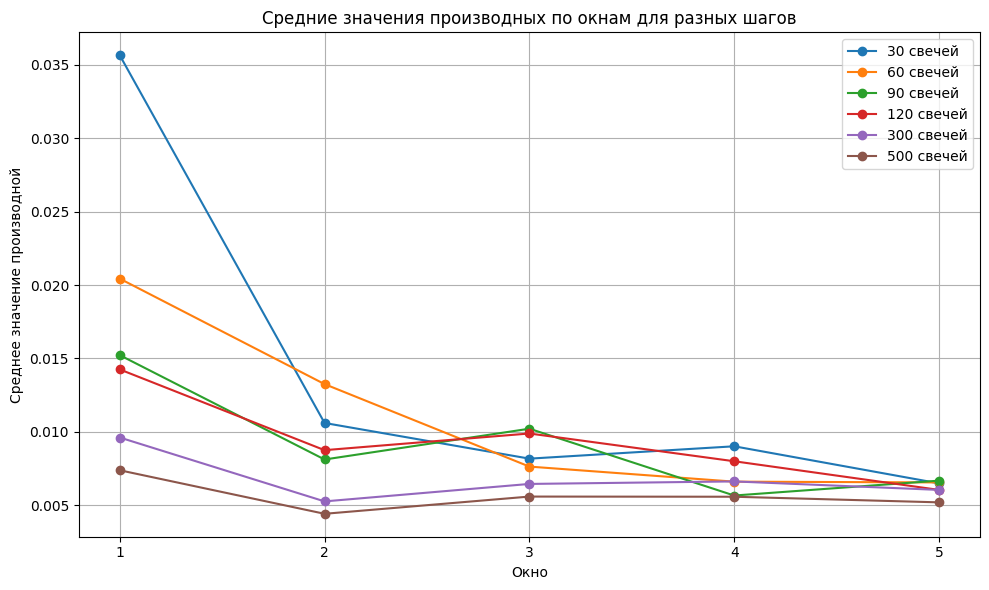

In [135]:
data = FinData("../datasets/Sber_1_min.csv")
df = data.df
df = add_news_to_df(df, news_df, merge_row_df='utc', merge_row_news='adjusted_date')

# Фильтрация 
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-06-30 23:59:59')
df_3m = df[(df['utc'] >= start_date) & (df['utc'] <= end_date)].copy()


# Шаги для анализа
steps_list = [30, 60, 90, 120, 300, 500]
window_size = 30
num_windows = 5
change_threshold = 0.6

# Для хранения результатов
mean_derivs_dict = {}

for step in steps_list:
    # 1. Посчитать изменения цен для текущего шага
    df_changes = compute_price_changes_all(df_3m, steps=[step])
    change_col = f'pct_change_{step}'
    hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
    hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

    top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
    df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

    # 4. Посчитать производные по новостям с этими хэштегами и значимым изменением
    df_derivs_step = compute_derivatives_for_significant_tagged_news(
        df_changes,
        change_col=change_col,
        change_threshold=change_threshold,
        window_size=window_size,
        num_windows=num_windows,
        price_col='close'
    )

    # 5. Средние значения производных по окнам
    if not df_derivs_step.empty:
        mean_derivs = df_derivs_step[[f'deriv_{i}' for i in range(num_windows)]].mean()
        mean_derivs_dict[step] = mean_derivs

# Визуализация
plt.figure(figsize=(10, 6))
for step, mean_derivs in mean_derivs_dict.items():
    plt.plot(range(1, num_windows + 1), mean_derivs.values, marker='o', label=f'{step} свечей')
plt.xlabel('Окно')
plt.ylabel('Среднее значение производной')
plt.title('Средние значения производных по окнам для разных шагов')
plt.xticks(range(1, num_windows + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

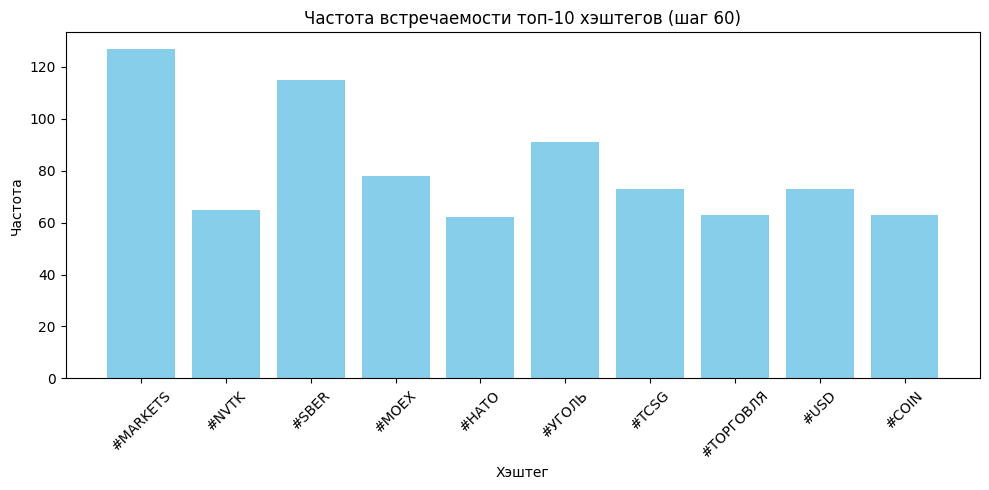

In [136]:
from collections import Counter

# Выбираем шаг 60
step = 60
change_col = f'pct_change_{step}'

df_changes = compute_price_changes_all(df_3m, steps=[step])
change_col = f'pct_change_{step}'
hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

# Приводим к верхнему регистру для сопоставления
top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]

# Фильтруем строки, где есть хотя бы один из топ-хэштегов
def has_any_top_hashtag(tags):
    tags_flat = [tag.upper() for sublist in tags for tag in (sublist if isinstance(sublist, list) else [sublist])]
    return any(h in tags_flat for h in top_hashtags_upper)

filtered_rows = df_3m[df_3m['hashtags'].apply(has_any_top_hashtag)]

# Считаем частоты встречаемости каждого хэштега из топа

all_tags = []
for tags in filtered_rows['hashtags']:
    for sublist in tags:
        if isinstance(sublist, list):
            all_tags.extend([tag.upper() for tag in sublist if tag.upper() in top_hashtags_upper])
        elif isinstance(sublist, str):
            tag = sublist.upper()
            if tag in top_hashtags_upper:
                all_tags.append(tag)

tag_counts = Counter(all_tags)
tag_counts = {tag: tag_counts[tag] for tag in top_hashtags_upper}

# Барплот
plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.xlabel('Хэштег')
plt.ylabel('Частота')
plt.title('Частота встречаемости топ-10 хэштегов (шаг 60)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [137]:
# Параметры
step = 60


df_changes = compute_price_changes_all(df_3m, steps=[step])
change_col = f'pct_change_{step}'
hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

change_col = f'pct_change_{step}'
change_threshold = 0.8
top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]

print(top_hashtags_upper)

def get_upper_tags(tags):
    result = []
    if isinstance(tags, list):
        for t in tags:
            if isinstance(t, list):
                result.extend([x.upper() for x in t if isinstance(x, str)])
            elif isinstance(t, str):
                result.append(t.upper())
    return result


df_changes['hashtags_upper'] = df_changes['hashtags'].apply(get_upper_tags)
# print(df_changes)
# print(df_changes['hashtags_upper'])

# Подсчёт реакции на каждый хэштег
hashtag_stats = []

for hashtag in top_hashtags_upper:
    rows_with_tag = df_changes[
        (df_changes['hashtags_upper'].apply(lambda tags: hashtag in tags)) &
        (df_changes[change_col].abs() >= change_threshold)
    ]

    changes = []
    for _, row in rows_with_tag.iterrows():
        news_list = row['news']
        tag_list = row['hashtags']
        if not isinstance(news_list, list) or not isinstance(tag_list, list):
            continue
        for tags in tag_list:
            tags_upper = [t.upper() for t in tags if isinstance(t, str)]
            if hashtag in tags_upper:
                changes.append(abs(row[change_col]))
                break  # один раз на новость

    if changes:
        mean_change = np.mean(changes)
        median_change = np.median(changes)
        hashtag_stats.append((hashtag, mean_change, median_change, len(changes)))

# Сортировка по среднему изменению
hashtag_stats.sort(key=lambda x: x[1], reverse=True)

# Вывод
print("Топ хэштегов по реакции компании:")
print(f"{'Хэштег':<15} {'Среднее изменение':<20} {'Медиана':<12} {'N новостей'}")
for tag, mean_c, med_c, count in hashtag_stats:
    print(f"{tag:<15} {mean_c:<20.4f} {med_c:<12.4f} {count}")


non_top_rows = df_changes[
    df_changes['hashtags_upper'].apply(lambda tags: any(t not in top_hashtags_upper for t in tags))
]

changes_non_top = non_top_rows[change_col].abs()

mean_change_non_top = changes_non_top.mean()
median_change_non_top = changes_non_top.median()
count_non_top = len(changes_non_top)

no_news_rows = df_changes[
    df_changes['hashtags_upper'].apply(lambda tags: len(tags) == 0)
]


changes_no_news = no_news_rows[change_col].abs()

mean_change_no_news = changes_no_news.mean()
median_change_no_news = changes_no_news.median()
count_no_news = len(changes_no_news)


print("\nКонтрольные выборки:")

print(f"{'Категория':<25} {'Среднее изменение':<20} {'Медиана':<12} {'N'}")
print(f"{'НЕ топ-хэштеги':<25} {mean_change_non_top:<20.4f} {median_change_non_top:<12.4f} {count_non_top}")
print(f"{'Без новостей':<25} {mean_change_no_news:<20.4f} {median_change_no_news:<12.4f} {count_no_news}")



['#MARKETS', '#NVTK', '#SBER', '#MOEX', '#НАТО', '#УГОЛЬ', '#TCSG', '#ТОРГОВЛЯ', '#USD', '#COIN']
Топ хэштегов по реакции компании:
Хэштег          Среднее изменение    Медиана      N новостей
#MOEX           1.5707               1.6016       3
#УГОЛЬ          1.5545               1.5545       2
#NVTK           1.4871               1.6295       3
#COIN           1.2255               1.2255       2
#SBER           1.1661               1.0955       5
#MARKETS        1.0420               0.8603       4
#НАТО           0.8869               0.8869       1
#USD            0.8258               0.8258       2
#TCSG           0.8179               0.8179       1

Контрольные выборки:
Категория                 Среднее изменение    Медиана      N
НЕ топ-хэштеги            0.1523               0.0995       11249
Без новостей              0.1227               0.0798       126389


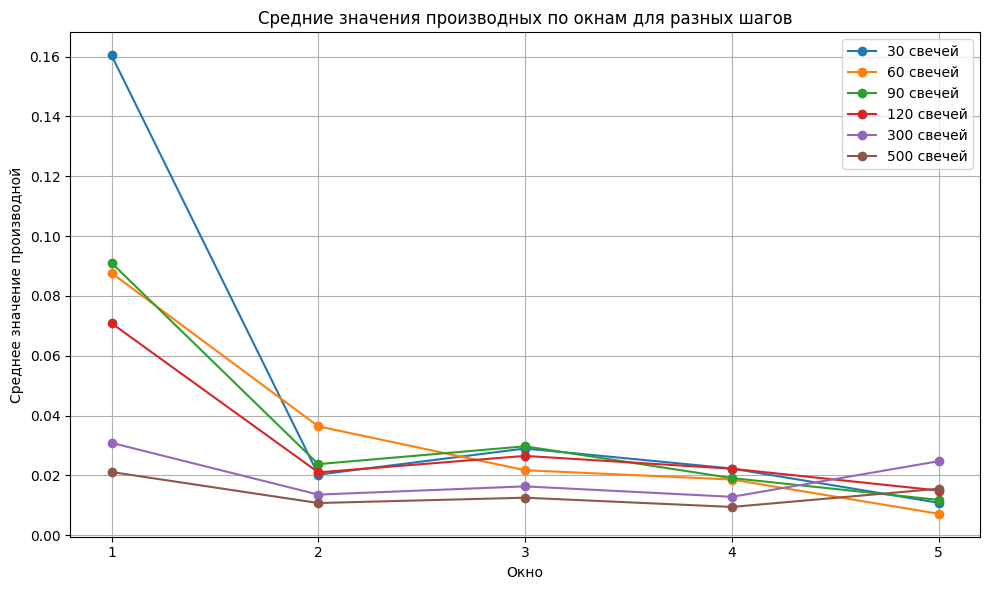

In [138]:
data = FinData("../datasets/Moex_1_min.csv")
df = data.df
df = add_news_to_df(df, news_df, merge_row_df='utc', merge_row_news='adjusted_date')

# Фильтрация 
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-06-30 23:59:59')
df_3m = df[(df['utc'] >= start_date) & (df['utc'] <= end_date)].copy()


# Шаги для анализа
steps_list = [30, 60, 90, 120, 300, 500]
window_size = 30
num_windows = 5
change_threshold = 1.9

# Для хранения результатов
mean_derivs_dict = {}

for step in steps_list:
    # 1. Посчитать изменения цен для текущего шага
    df_changes = compute_price_changes_all(df_3m, steps=[step])
    change_col = f'pct_change_{step}'
    hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
    hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

    top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
    df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

    # 4. Посчитать производные по новостям с этими хэштегами и значимым изменением
    df_derivs_step = compute_derivatives_for_significant_tagged_news(
        df_changes,
        change_col=change_col,
        change_threshold=change_threshold,
        window_size=window_size,
        num_windows=num_windows,
        price_col='close'
    )

    # 5. Средние значения производных по окнам
    if not df_derivs_step.empty:
        mean_derivs = df_derivs_step[[f'deriv_{i}' for i in range(num_windows)]].mean()
        mean_derivs_dict[step] = mean_derivs

# Визуализация
plt.figure(figsize=(10, 6))
for step, mean_derivs in mean_derivs_dict.items():
    plt.plot(range(1, num_windows + 1), mean_derivs.values, marker='o', label=f'{step} свечей')
plt.xlabel('Окно')
plt.ylabel('Среднее значение производной')
plt.title('Средние значения производных по окнам для разных шагов')
plt.xticks(range(1, num_windows + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

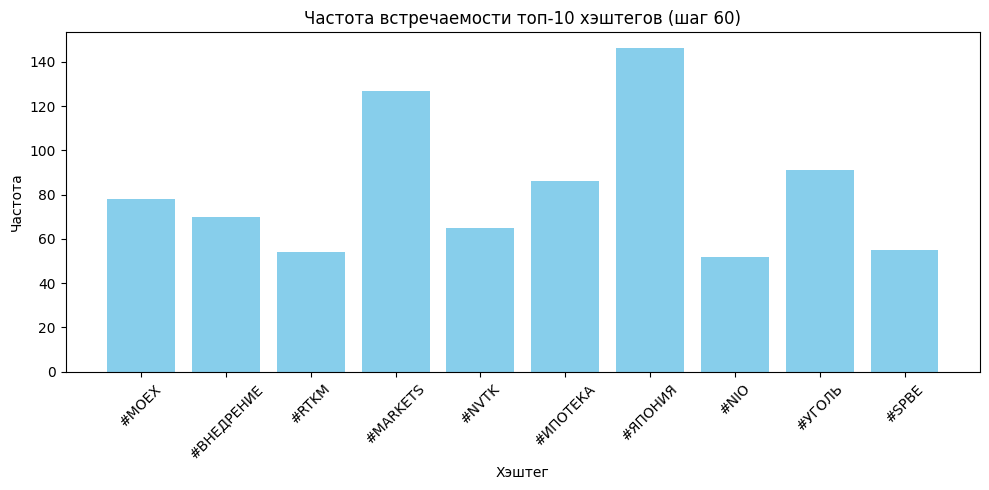

In [139]:
from collections import Counter

# Выбираем шаг 60
step = 60
change_col = f'pct_change_{step}'

df_changes = compute_price_changes_all(df_3m, steps=[step])
change_col = f'pct_change_{step}'
hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

# Приводим к верхнему регистру для сопоставления
top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]

# Фильтруем строки, где есть хотя бы один из топ-хэштегов
def has_any_top_hashtag(tags):
    tags_flat = [tag.upper() for sublist in tags for tag in (sublist if isinstance(sublist, list) else [sublist])]
    return any(h in tags_flat for h in top_hashtags_upper)

filtered_rows = df_3m[df_3m['hashtags'].apply(has_any_top_hashtag)]

# Считаем частоты встречаемости каждого хэштега из топа

all_tags = []
for tags in filtered_rows['hashtags']:
    for sublist in tags:
        if isinstance(sublist, list):
            all_tags.extend([tag.upper() for tag in sublist if tag.upper() in top_hashtags_upper])
        elif isinstance(sublist, str):
            tag = sublist.upper()
            if tag in top_hashtags_upper:
                all_tags.append(tag)

tag_counts = Counter(all_tags)
tag_counts = {tag: tag_counts[tag] for tag in top_hashtags_upper}

# Барплот
plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.xlabel('Хэштег')
plt.ylabel('Частота')
plt.title('Частота встречаемости топ-10 хэштегов (шаг 60)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [140]:
df_changes.head(1)

utc     open   close     high     low  volume  \
1020038 2024-01-02 07:17:00  190.365  188.87  190.382  188.87      10   

         direction_binary_0  direction_binary_1  \
1020038                   0                   1   

                                                      news  \
1020038  [🇺🇸#акции #сша #история #наблюдение \nИсториче...   

                                                     dates  \
1020038  [2024-01-01 18:09:45, 2024-01-01 17:59:40, 202...   

                                                  hashtags  pct_change_60  
1020038  [[#акции, #сша, #история, #наблюдение, #sentim...        0.82067

In [141]:
print(df_changes['hashtags'].head(10))
print(df_changes['hashtags'].apply(type).value_counts())


1020038    [[#акции, #сша, #история, #наблюдение, #sentim...
1020039                                                   []
1020040                                                   []
1020041                                                   []
1020042                                                   []
1020043                                                   []
1020044                                                   []
1020045                                                   []
1020046                                                   []
1020047                                                   []
Name: hashtags, dtype: object
hashtags
<class 'list'>    123611
Name: count, dtype: int64


In [142]:
df_changes

utc        open   close     high         low  volume  \
1020038 2024-01-02 07:17:00  190.365000  188.87  190.382  188.870000      10   
1020039 2024-01-02 07:18:00  188.870000  188.87  188.870  188.870000       2   
1020040 2024-01-02 07:19:00  190.394286  190.41  190.410  190.394286      47   
1020041 2024-01-02 07:20:00  190.410000  190.39  190.410  190.360000      16   
1020042 2024-01-02 07:21:00  189.000000  190.45  190.450  189.000000      44   
...                     ...         ...     ...      ...         ...     ...   
1143644 2024-06-30 20:39:00  229.870000  229.87  229.870  229.870000       2   
1143645 2024-06-30 20:43:00  229.480000  229.48  229.480  229.480000       2   
1143646 2024-06-30 20:44:00  229.850000  229.88  229.880  229.850000      12   
1143647 2024-06-30 20:45:00  229.480000  229.48  229.480  229.480000       2   
1143648 2024-06-30 20:48:00  229.480000  229.48  229.480  229.480000       2   

         direction_binary_0  direction_binary_1  \
1020038                   0                   1   
1020039                   1                   1   
1020040                   0                   0   
1020041                   1                   1   
1020042                   0                   0   
...                     ...                 ...   
1143644                   0                   0   
1143645                   1                   1   
1143646                   0                   0   
1143647                   0                   1   
1143648                   0                   0   

                                                      news  \
1020038  [🇺🇸#акции #сша #история #наблюдение \nИсториче...   
1020039                                                 []   
1020040                                                 []   
1020041                                                 []   
1020042                                                 []   
...                                                    ...   
1143644                                                 []   
1143645                                                 []   
1143646                                                 []   
1143647                                                 []   
1143648                                                 []   

                                                     dates  \
1020038  [2024-01-01 18:09:45, 2024-01-01 17:59:40, 202...   
1020039                                                 []   
1020040                                                 []   
1020041                                                 []   
1020042                                                 []   
...                                                    ...   
1143644                                                 []   
1143645                                                 []   
1143646                                                 []   
1143647                                                 []   
1143648                                                 []   

                                                  hashtags  pct_change_60  
1020038  [[#акции, #сша, #история, #наблюдение, #sentim...       0.820670  
1020039                                                 []       0.820670  
1020040                                                 []       0.005252  
1020041                                                 []      -0.236357  
1020042                                                 []      -0.267787  
...                                                    ...            ...  
1143644                                                 []            NaN  
1143645                                                 []            NaN  
1143646                                                 []            NaN  
1143647                                                 []            NaN  
1143648                                                 []            NaN  

[123611 rows x 12 columns]

In [143]:
# Параметры
step = 60


df_changes = compute_price_changes_all(df_3m, steps=[step])
change_col = f'pct_change_{step}'
hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

change_col = f'pct_change_{step}'
change_threshold = 0.6
top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]

print(top_hashtags_upper)

def get_upper_tags(tags):
    result = []
    if isinstance(tags, list):
        for t in tags:
            if isinstance(t, list):
                result.extend([x.upper() for x in t if isinstance(x, str)])
            elif isinstance(t, str):
                result.append(t.upper())
    return result


df_changes['hashtags_upper'] = df_changes['hashtags'].apply(get_upper_tags)
# print(df_changes)
# print(df_changes['hashtags_upper'])

# Подсчёт реакции на каждый хэштег
hashtag_stats = []

for hashtag in top_hashtags_upper:
    rows_with_tag = df_changes[
        (df_changes['hashtags_upper'].apply(lambda tags: hashtag in tags)) &
        (df_changes[change_col].abs() >= change_threshold)
    ]

    changes = []
    for _, row in rows_with_tag.iterrows():
        news_list = row['news']
        tag_list = row['hashtags']
        if not isinstance(news_list, list) or not isinstance(tag_list, list):
            continue
        for tags in tag_list:
            tags_upper = [t.upper() for t in tags if isinstance(t, str)]
            if hashtag in tags_upper:
                changes.append(abs(row[change_col]))
                break  # один раз на новость

    if changes:
        mean_change = np.mean(changes)
        median_change = np.median(changes)
        hashtag_stats.append((hashtag, mean_change, median_change, len(changes)))

# Сортировка по среднему изменению
hashtag_stats.sort(key=lambda x: x[1], reverse=True)

# Вывод
print("Топ хэштегов по реакции компании:")
print(f"{'Хэштег':<15} {'Среднее изменение':<20} {'Медиана':<12} {'N новостей'}")
for tag, mean_c, med_c, count in hashtag_stats:
    print(f"{tag:<15} {mean_c:<20.4f} {med_c:<12.4f} {count}")


['#MOEX', '#ВНЕДРЕНИЕ', '#RTKM', '#MARKETS', '#NVTK', '#ИПОТЕКА', '#ЯПОНИЯ', '#NIO', '#УГОЛЬ', '#SPBE']
Топ хэштегов по реакции компании:
Хэштег          Среднее изменение    Медиана      N новостей
#NIO            1.9701               0.8425       7
#ВНЕДРЕНИЕ      1.9038               0.9869       12
#NVTK           1.6419               0.9560       11
#MOEX           1.6275               0.8621       19
#ИПОТЕКА        1.5794               0.9994       14
#RTKM           1.5050               0.7810       11
#ЯПОНИЯ         1.4047               0.8091       22
#SPBE           1.3634               1.1179       10
#УГОЛЬ          1.2700               0.7549       18
#MARKETS        1.1845               0.8013       31


In [144]:
non_top_rows = df_changes[
    df_changes['hashtags_upper'].apply(lambda tags: any(t not in top_hashtags_upper for t in tags)) &
    (df_changes[change_col].abs() >= change_threshold)
]

changes_non_top = non_top_rows[change_col].abs()

mean_change_non_top = changes_non_top.mean()
median_change_non_top = changes_non_top.median()
count_non_top = len(changes_non_top)

no_news_rows = df_changes[
    df_changes['hashtags_upper'].apply(lambda tags: len(tags) == 0) &
    (df_changes[change_col].abs() >= change_threshold)
]

changes_no_news = no_news_rows[change_col].abs()

mean_change_no_news = changes_no_news.mean()
median_change_no_news = changes_no_news.median()
count_no_news = len(changes_no_news)


print("\nКонтрольные выборки:")

print(f"{'Категория':<25} {'Среднее изменение':<20} {'Медиана':<12} {'N'}")
print(f"{'НЕ топ-хэштеги':<25} {mean_change_non_top:<20.4f} {median_change_non_top:<12.4f} {count_non_top}")
print(f"{'Без новостей':<25} {mean_change_no_news:<20.4f} {median_change_no_news:<12.4f} {count_no_news}")



Контрольные выборки:
Категория                 Среднее изменение    Медиана      N
НЕ топ-хэштеги            0.9956               0.7969       1025
Без новостей              1.0061               0.8084       7878


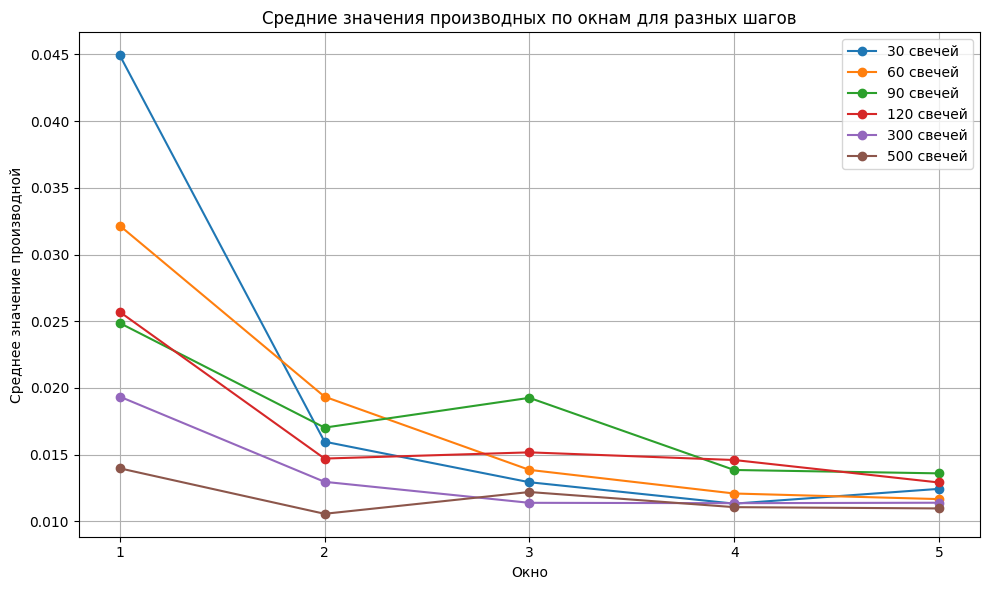

In [145]:
data = FinData("../datasets/Whoosh_1_min.csv")
df = data.df
df = add_news_to_df(df, news_df, merge_row_df='utc', merge_row_news='adjusted_date')

# Фильтрация 
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-06-30 23:59:59')
df_3m = df[(df['utc'] >= start_date) & (df['utc'] <= end_date)].copy()


# Шаги для анализа
steps_list = [30, 60, 90, 120, 300, 500]
window_size = 30
num_windows = 5
change_threshold = 0.6

# Для хранения результатов
mean_derivs_dict = {}

for step in steps_list:
    # 1. Посчитать изменения цен для текущего шага
    df_changes = compute_price_changes_all(df_3m, steps=[step])
    change_col = f'pct_change_{step}'
    hashtag_impact = compute_hashtag_influence(df_changes, change_col=change_col)
    hashtags_for_gazprom = hashtag_impact[hashtag_impact.counts > 50].head(10)['hashtag'].tolist()

    top_hashtags_upper = [h.upper() for h in hashtags_for_gazprom]
    df_changes['has_tags'] = df_changes['hashtags'].apply(lambda tags: contains_keywords(tags, top_hashtags_upper))

    # 4. Посчитать производные по новостям с этими хэштегами и значимым изменением
    df_derivs_step = compute_derivatives_for_significant_tagged_news(
        df_changes,
        change_col=change_col,
        change_threshold=change_threshold,
        window_size=window_size,
        num_windows=num_windows,
        price_col='close'
    )

    # 5. Средние значения производных по окнам
    if not df_derivs_step.empty:
        mean_derivs = df_derivs_step[[f'deriv_{i}' for i in range(num_windows)]].mean()
        mean_derivs_dict[step] = mean_derivs

# Визуализация
plt.figure(figsize=(10, 6))
for step, mean_derivs in mean_derivs_dict.items():
    plt.plot(range(1, num_windows + 1), mean_derivs.values, marker='o', label=f'{step} свечей')
plt.xlabel('Окно')
plt.ylabel('Среднее значение производной')
plt.title('Средние значения производных по окнам для разных шагов')
plt.xticks(range(1, num_windows + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()